### Install dependencies

In [ ]:
!pip install shapely

In [1]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder
                    .appName('project1')
                    .enableHiveSupport()
                    .getOrCreate()
        )

25/03/09 17:42:14 WARN Utils: Your hostname, Nikas-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 172.31.168.218 instead (on interface en0)
25/03/09 17:42:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/09 17:42:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/09 17:42:15 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Load the data

In [2]:
# Load NYC taxi trips dataset 
taxi_df = (spark.read
            .option("header", "true")
            .option("inferSchema", "true")
            .csv("input/Sample NYC Data.csv")
          )

display(taxi_df)

# Load boroughs GeoJSON data
boroughs_df = (spark.read.option("inferSchema", True).option("multiline", True).json("input/nyc-boroughs.geojson"))
display(boroughs_df)

DataFrame[medallion: string, hack_license: string, vendor_id: string, rate_code: int, store_and_fwd_flag: string, pickup_datetime: string, dropoff_datetime: string, passenger_count: int, pickup_longitude: double, pickup_latitude: double, dropoff_longitude: double, dropoff_latitude: double]

DataFrame[features: array<struct<geometry:struct<coordinates:array<array<array<double>>>,type:string>,id:bigint,properties:struct<@id:string,borough:string,boroughCode:bigint>,type:string>>, type: string]

## Enriching dataset with borough names

In [3]:
from shapely.geometry import Polygon
from pyspark.sql.functions import explode, col, udf

# udfs for shapely polygon creation and area calculation
def create_polygon(coordinates):
    return Polygon(coordinates[0]).wkt # wkt format can be deserialzed

def calculate_area(coordinates):
    return Polygon(coordinates[0]).area
    
create_polygon_udf = udf(create_polygon)
calculate_area_udf = udf(calculate_area)

In [4]:
from pyspark.sql.types import DoubleType

# explode the features array
boroughs_features_df = boroughs_df.select(explode(col("features")).alias("feature"))

boroughs_features_df.head()

# dataframe enriched with polygon and area
borough_geo_df = (
    boroughs_features_df.select(
        col("feature.properties.borough").alias("borough"),
        col("feature.properties.boroughCode").alias("boroughCode"),
        col("feature.geometry.coordinates").alias("coordinates")
    )
    .withColumn("polygon", create_polygon_udf(col("coordinates")))
    .withColumn("area", calculate_area_udf(col("coordinates")))
)

# cast area to double
borough_geo_df = borough_geo_df.withColumn("area", col("area").cast(DoubleType()))

In [5]:
from pyspark.sql.functions import desc, asc
from shapely.wkt import dumps

# sort the dataframe by boroughCode and area
boroughs_sorted = borough_geo_df.orderBy("boroughCode", desc("area"))
boroughs_sorted.select("borough", "area").show(20, truncate=False)

# broadcast the sorted boroughs dataframe
borough_bd = spark.sparkContext.broadcast(boroughs_sorted.collect())

+---------+---------------------+
|borough  |area                 |
+---------+---------------------+
|Manhattan|0.005859077996035753 |
|Manhattan|2.3271655856762013E-4|
|Manhattan|7.6037752599342E-5   |
|Manhattan|6.23157479510608E-5  |
|Manhattan|3.2658591272044954E-5|
|Manhattan|1.1828883137677094E-5|
|Manhattan|6.143638903459381E-6 |
|Manhattan|3.3831273674444417E-6|
|Manhattan|2.858823502476497E-6 |
|Manhattan|2.393654308790746E-6 |
|Manhattan|2.3345540772235924E-6|
|Manhattan|2.2627340976761147E-6|
|Manhattan|2.2465297475388565E-6|
|Manhattan|2.24116737819868E-6  |
|Manhattan|2.2094455927089308E-6|
|Manhattan|2.0486362960502745E-6|
|Manhattan|1.3300494774255711E-6|
|Manhattan|1.1111770551654054E-6|
|Manhattan|2.354033827718773E-7 |
|Manhattan|2.0929022926724522E-7|
+---------+---------------------+
only showing top 20 rows



In [6]:
from pyspark.sql.types import StringType
from shapely.geometry import Point
from shapely.wkt import loads

# udf for getting borough
def get_borough(lat, lon):
    if lat is None or lon is None:
        return "unknown"
    
    point = Point(lon, lat)
    for row in borough_bd.value:
        if loads(row["polygon"]).contains(point):
            return row["borough"]
    return "unknown"

get_borough_udf = udf(get_borough)   

In [7]:
taxi_df = taxi_df.filter(
    col("pickup_latitude").isNotNull() &
    col("pickup_longitude").isNotNull() &
    col("dropoff_latitude").isNotNull() &
    col("dropoff_longitude").isNotNull()
)
 
taxi_df = taxi_df.withColumn("pickup_borough", get_borough_udf(col("pickup_latitude"), col("pickup_longitude")))
taxi_df = taxi_df.withColumn("dropoff_borough", get_borough_udf(col("dropoff_latitude"), col("dropoff_longitude")))

# taxi_df.show()
taxi_df.select("pickup_borough", "dropoff_borough", "medallion", "pickup_datetime", "dropoff_datetime").show(20)

+--------------+---------------+--------------------+---------------+----------------+
|pickup_borough|dropoff_borough|           medallion|pickup_datetime|dropoff_datetime|
+--------------+---------------+--------------------+---------------+----------------+
|     Manhattan|      Manhattan|89D227B655E5C82AE...| 01-01-13 15:11|  01-01-13 15:18|
|     Manhattan|      Manhattan|0BD7C8F5BA12B88E0...| 06-01-13 00:18|  06-01-13 00:22|
|     Manhattan|      Manhattan|0BD7C8F5BA12B88E0...| 05-01-13 18:49|  05-01-13 18:54|
|     Manhattan|      Manhattan|DFD2202EE08F7A8DC...| 07-01-13 23:54|  07-01-13 23:58|
|     Manhattan|      Manhattan|DFD2202EE08F7A8DC...| 07-01-13 23:25|  07-01-13 23:34|
|     Manhattan|      Manhattan|20D9ECB2CA0767CF7...| 07-01-13 15:27|  07-01-13 15:38|
|     Manhattan|      Manhattan|496644932DF393260...| 08-01-13 11:01|  08-01-13 11:08|
|     Manhattan|         Queens|0B57B9633A2FECD3D...| 07-01-13 12:39|  07-01-13 13:10|
|     Manhattan|      Manhattan|2C0E91FF20A

## Data cleansing

### For real data set

In [8]:
from pyspark.sql.functions import unix_timestamp, col

time_format = "dd-MM-yy HH:mm"

taxi_df = (
    taxi_df
    .withColumn("pickup_timestamp", unix_timestamp(col("pickup_datetime"), time_format))
    .withColumn("dropoff_timestamp", unix_timestamp(col("dropoff_datetime"), time_format))
    .withColumn("duration", col("dropoff_timestamp") - col("pickup_timestamp"))
)

taxi_df.select(
    "pickup_timestamp",
    "dropoff_timestamp",
    "pickup_datetime",
    "dropoff_datetime",
    "duration",
    "pickup_borough",
    "dropoff_borough",
    "medallion"
).show(20)


+----------------+-----------------+---------------+----------------+--------+--------------+---------------+--------------------+
|pickup_timestamp|dropoff_timestamp|pickup_datetime|dropoff_datetime|duration|pickup_borough|dropoff_borough|           medallion|
+----------------+-----------------+---------------+----------------+--------+--------------+---------------+--------------------+
|      1357045860|       1357046280| 01-01-13 15:11|  01-01-13 15:18|     420|     Manhattan|      Manhattan|89D227B655E5C82AE...|
|      1357424280|       1357424520| 06-01-13 00:18|  06-01-13 00:22|     240|     Manhattan|      Manhattan|0BD7C8F5BA12B88E0...|
|      1357404540|       1357404840| 05-01-13 18:49|  05-01-13 18:54|     300|     Manhattan|      Manhattan|0BD7C8F5BA12B88E0...|
|      1357595640|       1357595880| 07-01-13 23:54|  07-01-13 23:58|     240|     Manhattan|      Manhattan|DFD2202EE08F7A8DC...|
|      1357593900|       1357594440| 07-01-13 23:25|  07-01-13 23:34|     540|     

### Test Total Count

In [9]:
# filter out the trips with invalid duration
print(taxi_df.count())

max_trip_duration = 4 * 60 * 60 # 4 hours

filtered_taxi_df = taxi_df.filter((col("duration") > 0) & (col("duration") <= max_trip_duration))
print(filtered_taxi_df.count())


99999
99549


## Query 1 - Utilization 

In [10]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, sum as _sum, when

# partition data by medallion
window_spec = Window.partitionBy("medallion").orderBy("pickup_timestamp")

# add previous dropoff time as column
u_taxi_df = taxi_df.withColumn("prev_dropoff_timestamp", lag("dropoff_timestamp").over(window_spec))

# add idle time column
u_taxi_df = u_taxi_df.withColumn("idle_time", col("pickup_timestamp") - col("prev_dropoff_timestamp"))

session_threshold = 4 * 60 * 60
# if idle time is more than 4 hours, count consider it's a new session
u_taxi_df = u_taxi_df.withColumn(
    "idle_time",
    when(col("idle_time") <= session_threshold, col("idle_time")).otherwise(0)
)

# group by taxi ID and get the total idle time
utilization_df = (
    u_taxi_df
    .groupBy("medallion")
    .agg(_sum("duration").alias("busy_time_sum"),
         _sum("idle_time").alias("idle_time_sum")
    )
)

utilization_df = utilization_df.withColumn(
    "utilization_rate",
    col("busy_time_sum") / (col("busy_time_sum") + col("idle_time_sum"))
)

utilization_df.show(50)

+--------------------+-------------+-------------+-------------------+
|           medallion|busy_time_sum|idle_time_sum|   utilization_rate|
+--------------------+-------------+-------------+-------------------+
|000318C2E3E638158...|        13920|        17400| 0.4444444444444444|
|002E3B405B6ABEA23...|        10260|        16140| 0.3886363636363636|
|0030AD2648D81EE87...|         1980|          720| 0.7333333333333333|
|0036961468659D0BF...|        11700|        19740|0.37213740458015265|
|0038EF45118925A51...|        10920|        15120|0.41935483870967744|
|0053334C798EC6C8E...|         7920|        22440| 0.2608695652173913|
|005DED7D6E6C45441...|        11460|        11760| 0.4935400516795866|
|005F00B38F46E2100...|        18600|        42180| 0.3060217176702863|
|00790C7BAD30B7A9E...|        12360|        25320|0.32802547770700635|
|0094A03FFE6BAFBE0...|        10680|         5400|  0.664179104477612|
|009D3CCA83486B03F...|        19620|        40920| 0.3240832507433102|
|009E6

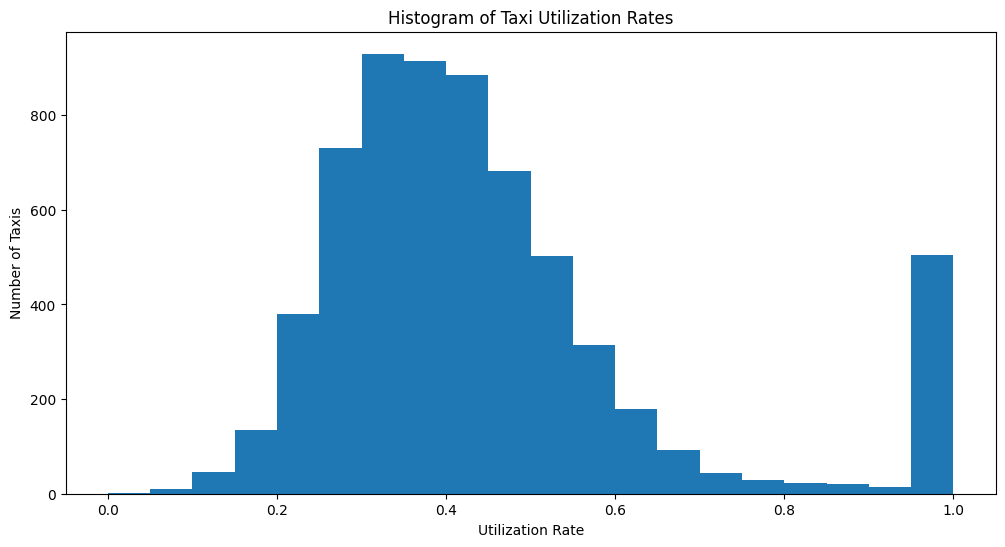

In [12]:
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to pandas
pdf = utilization_df.toPandas()

# Increase the figure size to make the chart bigger
plt.figure(figsize=(12, 6))

# Plot a histogram of the utilization_rate
plt.hist(pdf["utilization_rate"], bins=20)
plt.xlabel("Utilization Rate")
plt.ylabel("Number of Taxis")
plt.title("Histogram of Taxi Utilization Rates")
plt.show()


## Query 3 - Average time for taxi to find next fare per destination borough

In [13]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lead, avg, col

a_taxi_df = taxi_df.select("medallion", "dropoff_borough", "pickup_timestamp", "dropoff_timestamp")
a_taxi_df = a_taxi_df.repartition("medallion")
window_spec = Window.partitionBy("medallion").orderBy("dropoff_timestamp")
a_taxi_df = a_taxi_df.withColumn("next_pickup_timestamp", lead("pickup_timestamp").over(window_spec))
a_taxi_df = a_taxi_df.withColumn("time_to_next_fare", col("next_pickup_timestamp") - col("dropoff_timestamp"))
a_taxi_df = a_taxi_df.persist()
avg_time_per_borough = (
    a_taxi_df.groupBy("dropoff_borough")
    .agg(avg("time_to_next_fare").alias("avg_time_to_next_fare"))
)
avg_time_per_borough = avg_time_per_borough.repartition(1)
avg_time_per_borough.show()

+---------------+---------------------+
|dropoff_borough|avg_time_to_next_fare|
+---------------+---------------------+
|         Queens|    6368.423432682425|
|        unknown|   12206.935332708528|
|       Brooklyn|    6554.840325610519|
|      Manhattan|   2048.9211563256895|
|          Bronx|    4973.719008264463|
|  Staten Island|              13935.0|
+---------------+---------------------+



## Query 3 - The number of trips that started and ended within the same borough

In [14]:
from pyspark.sql.functions import count

same_borough_trips_df = filtered_taxi_df.filter(col("pickup_borough") == col("dropoff_borough"))
print("The number of trips that started and ended within the same borough:", same_borough_trips_df.count())

The number of trips that started and ended within the same borough: 87477


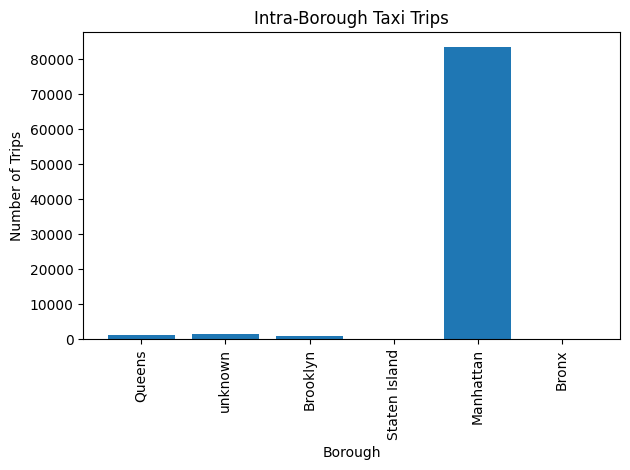

In [15]:
borough_counts = same_borough_trips_df.groupBy("pickup_borough").agg(count("*").alias("trip_count"))

boroughs = [row.pickup_borough for row in borough_counts.collect()]
counts = [row.trip_count for row in borough_counts.collect()]

plt.bar(boroughs, counts)
plt.xticks(rotation=90)
plt.xlabel("Borough")
plt.ylabel("Number of Trips")
plt.title("Intra-Borough Taxi Trips")
plt.tight_layout() #prevents labels from being cutoff
plt.show()

## Query 4 - Number of trips with start and end in different boroughs

In [ ]:

#  taxi_df = taxi_df.repartition("pickup_borough", "dropoff_borough")
diff_borough_trips_df = taxi_df.filter(col("pickup_borough") != col("dropoff_borough"))

# Trigger an action to see how many rows we have
total_diff_borough_trips = diff_borough_trips_df.count()
print("Total number of cross-borough trips:", total_diff_borough_trips)



Total number of cross-borough trips: 12120


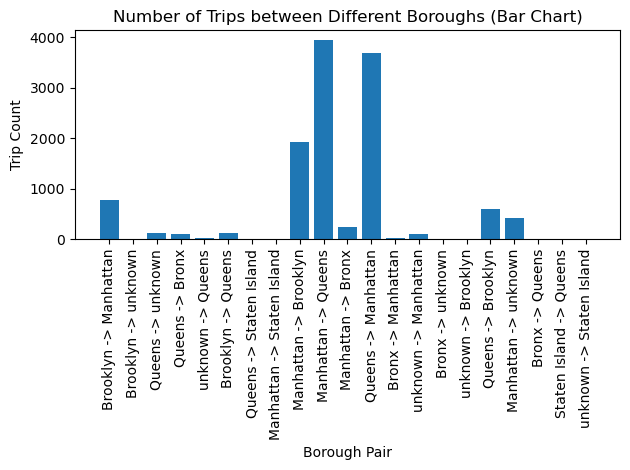

In [ ]:
#Breakdown by borough pair
breakdown_df = (
    diff_borough_trips_df
    .groupBy("pickup_borough", "dropoff_borough")
    .count()
)

import matplotlib.pyplot as plt

# Convert Spark DataFrame to pandas
pdf = breakdown_df.toPandas()

# Create a label for each (pickup_borough -> dropoff_borough) pair
pdf["borough_pair"] = pdf["pickup_borough"] + " -> " + pdf["dropoff_borough"]

# Plot a simple bar chart
plt.bar(pdf["borough_pair"], pdf["count"])
plt.xticks(rotation=90)  # Rotate x-axis labels so they're readable
plt.title("Number of Trips between Different Boroughs (Bar Chart)")
plt.xlabel("Borough Pair")
plt.ylabel("Trip Count")
plt.tight_layout()  # Helps prevent label cutoff
plt.show()


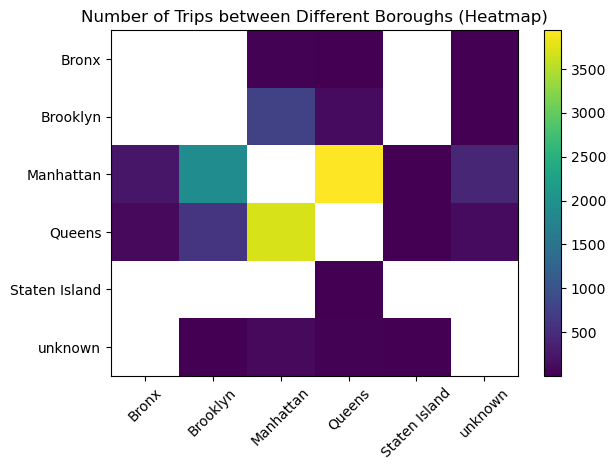

In [ ]:
import matplotlib.pyplot as plt

# Convert Spark DataFrame to pandas
pdf = breakdown_df.toPandas()

# Pivot so rows=pickup_borough, columns=dropoff_borough, values=count
pivot_df = pdf.pivot(
    index="pickup_borough",
    columns="dropoff_borough",
    values="count"
)

# Create a heatmap-like plot
plt.imshow(pivot_df, aspect="auto")
plt.xticks(range(len(pivot_df.columns)), pivot_df.columns, rotation=45)
plt.yticks(range(len(pivot_df.index)), pivot_df.index)
plt.colorbar()  # Show a color scale legend
plt.title("Number of Trips between Different Boroughs (Heatmap)")
plt.tight_layout()
plt.show()
